# Домашнее задание 5
В этом задании мы:

1. Построим U-Net для датасета VOC segmentation, посмотрим на качество семантической сегментации.
2. Соберем GAN для генерации картинок из MNIST.
3. Прикрутим к этому GAN обуславливание на метку класса, посмотрим на результат.

## U-Net на датасете VOC

Датасет [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) - один из классических датасетов для задачи семантической сегментации.
Его используют в статьях и [по сей день](https://paperswithcode.com/dataset/pascal-voc) для бенчмарков.

В этом задании вам нужно скачать этот датасет, разбить на train и validation части, и обучить на нем U-Net.
Код для U-Net разбирался в семинаре.

В ЛМС необходимо сдать вашу реализацию U-Net и `model.pt` файл обученной модели.
Чтобы сдать это задание, модель должна достигать accuracy > 50% на тестовом датасете.

In [1]:
import typing as tp
from functools import reduce
from pathlib import Path

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from albumentations.pytorch.transforms import ToTensorV2
from IPython.display import clear_output, display
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation

100%|██████████| 1999639040/1999639040 [00:59<00:00, 33646176.38it/s]


Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


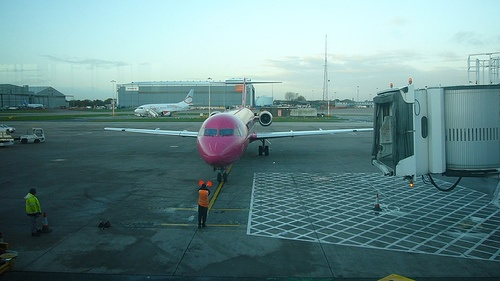

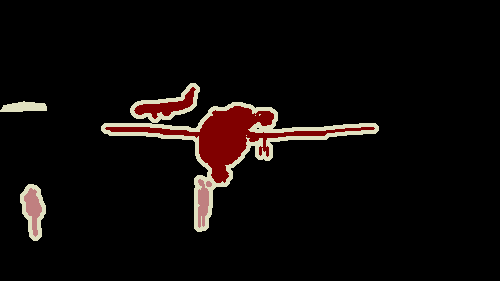

In [2]:
# Для начала загрузим датасет и посмотрим на его структуру
dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=not Path("./data").exists(),
)
display(dataset[0][0])
display(dataset[0][1])

В датасете маске присваивается 255 для границы объекта, а внутри объекта присваивается число от 0 до 20 - метка класса.

In [3]:
# Пройдемся по всем маскам датасета и возьмем уникальные значения в пикселях
reduce(
    lambda s1, s2: s1.union(s2),
    (set(np.unique(np.array(dataset[i][1])).tolist()) for i in range(len(dataset))),
    set(),
)
# Ага, действительно, метки классов от 0 до 20, при этом 0 означает "ничего интересного нет", а 255 означает границу

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 255}

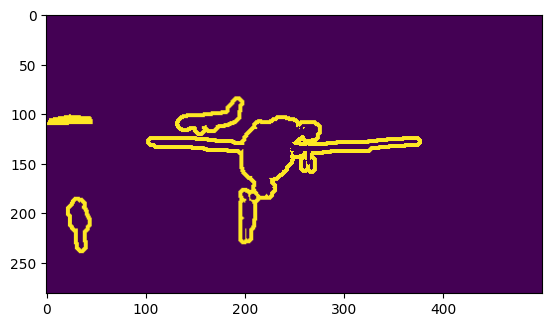

In [4]:
# Отрисуем только пиксели со значением 255 и убедимся, что они соответствуют границам объектов
plt.imshow(np.where(np.array(dataset[0][1]) == 255, 1, 0))

In [5]:
n_classes, img_size = 22, 256


def load_voc_dataset(split: tp.Literal["train", "val", "test"]):
    transforms = A.Compose(
        [
            A.Resize(img_size, img_size, interpolation=cv2.INTER_NEAREST),
            ToTensorV2(),
            A.Lambda(
                # Нормализуем изображение в отрезок [0, 1]
                image=lambda image, **_: image / 255.0,
                # Сделайте так, чтобы все классы шли друг от друга с шагом 1 (подумайте, что делать с классом 255)
                mask=lambda mask, **_: ...,
            ),
        ]
    )

    def _transform(image, mask):
        # Конвертируем из PIL формата в np.array за счет np.array(image).
        # Заметьте, image=..., mask=... - это указание, что есть изображение и что есть маска.
        # Albumentations в общем виде по-разному обрабатывает изображения и маски.
        transformed = transforms(image=np.array(image), mask=np.array(mask))
        return transformed["image"], transformed["mask"]

    # Создание датасета с нужными трансформациями
    dataset = VOCSegmentation(
        root="./data",
        year="2012",
        image_set=split,
        download=not Path("./data").exists(),
        transforms=_transform,
    )
    return dataset


train_dataset = load_voc_dataset("train")
val_dataset = load_voc_dataset("val")
print(train_dataset[0])
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

# Отрисовка изображения и маски
fig, ax = plt.subplots(3, 2, figsize=(9, 9))
for i in range(3):
    img, mask = train_dataset[i]
    ax[i][0].imshow(img.permute(1, 2, 0).numpy())
    ax[i][1].imshow(mask.numpy())
fig.show();

d:\python\DL_NLP_Course\.venv\Lib\site-packages\albumentations\augmentations\transforms.py:1803: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


(tensor([[[0.5137, 0.5137, 0.5216,  ..., 0.7176, 0.7137, 0.7137],
         [0.5176, 0.5176, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         [0.5216, 0.5216, 0.5255,  ..., 0.7216, 0.7176, 0.7176],
         ...,
         [0.0392, 0.0314, 0.0431,  ..., 0.0235, 0.0353, 0.0314],
         [0.0235, 0.0196, 0.0353,  ..., 0.0549, 0.0588, 0.0627],
         [0.0196, 0.0353, 0.0431,  ..., 0.0667, 0.0588, 0.0667]],

        [[0.7569, 0.7569, 0.7647,  ..., 0.9137, 0.9098, 0.9098],
         [0.7608, 0.7608, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         [0.7647, 0.7647, 0.7686,  ..., 0.9176, 0.9137, 0.9137],
         ...,
         [0.0627, 0.0549, 0.0588,  ..., 0.0980, 0.1059, 0.1059],
         [0.0588, 0.0549, 0.0549,  ..., 0.1294, 0.1294, 0.1333],
         [0.0549, 0.0706, 0.0627,  ..., 0.1412, 0.1294, 0.1373]],

        [[0.8157, 0.8157, 0.8235,  ..., 0.9412, 0.9451, 0.9451],
         [0.8196, 0.8196, 0.8275,  ..., 0.9451, 0.9490, 0.9490],
         [0.8235, 0.8235, 0.8275,  ..., 0.9451, 0.9490, 0

AttributeError: 'ellipsis' object has no attribute 'shape'

Теперь очередь за вами.
Обучите модель и сдайте её в ЛМС (инструкции выше).

Обратите внимание, что границы объекта выделены пикселем 255 - это немного выбивается из остальных классов, где метки идут с шагом 1 (0, 1, 2 и т.д. до 21).
Подумайте, как это исправить.

In [6]:
model = ...
torch.save(model.state_dict(), "model.pt")

## GAN на MNIST

Во второй части задания мы попробуем генерировать изображения с цифрами.
Для этого возьмем модель GAN и обучим ее на датасет MNIST.

Ваша задача: скачайте датасет MNIST, обучите на нем GAN, сохраните веса генератора и дискриминатора в `generator.pt` и `discriminator.pt` соответственно.
Сдайте в ЛМС:
1. Код генератора и его веса.
2. Код дискриминатора и его веса.

In [7]:
# Используйте следующие параметры модели
image_size = 28
# Размер латентного вектора - из него генератор будет создавать изображение
nz = 100

## GAN с условиями

Наш GAN генерирует картинку из случайного класса.
Однако можно научить его принимать на вход метку класса и генерировать картинку с этой меткой.
Такие GAN называются **Conditional GAN** (*обусловленный GAN*).

Добавить обуславливание достаточно просто:
1. Добавьте в генератор embedding-слой для метки класса. Берите небольшую размерность вектора, 10-ти хватит.
2. Поменяйте первый ConvTranspose2d так, чтобы тот принял вектор длины 110 (100 от рандома, 10 от эмбеддинга).
3. Поменяйте код `forward` так, чтобы в ConvTranspose2d передавать объединенный вектор размера 110.
4. Сделайте аналогичные изменения в `Discriminator` - он тоже должен принимать `label` как аргумент в `forward` и учитывать его. Подумайте, какие слои и как надо будет поменять.

Сделайте **Conditional GAN**, обучите его.
Сдайте в ЛМС:
1. Новый код `Generator` и его веса.
2. Новый код `Discriminator` и его веса.

Если вы все сделали правильно, у вас должны получиться правдоподобные картинки для каждого из классов.